In [5]:
import random
import os
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.nn.modules.distance import PairwiseDistance
from torch.nn.functional import cosine_similarity
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

d:\cctv_project\ai_final_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.facenet=InceptionResnetV1(pretrained='casia-webface',classify=False).eval()
    self.facenet.last_bn=torch.nn.Identity()
    self.facenet.logits=torch.nn.Identity()
    self.freeze()


  def freeze(self):
    for param in self.facenet.parameters():
      param.requires_grad_(False)

    for param in self.facenet.block8.parameters():
      param.requires_grad_(True)

    for param in self.facenet.last_linear.parameters():
      param.requires_grad_(True)

  def forward(self,x):

    return self.facenet(x)


In [8]:
device = "cpu"
model = Model().to(device)
state_dict=torch.load(r"D:\cctv_project\ai_final_project\models\facenet\fine_tuned\best_model_85.pth",map_location="cuda")
model.load_state_dict(state_dict)

d:\cctv_project\ai_final_project\venv\Lib\site-packages\facenet_pytorch\models\inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.l

<All keys matched successfully>

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import transforms, models
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# import os
# import numpy as np
# from tqdm import tqdm
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt


class AnchorDataset(Dataset):
    def __init__(self, root_dir):
        self.anchors = []
        self.labels = []
        for anchor_name in os.listdir(root_dir):
            self.anchors.append(os.path.join(root_dir, anchor_name))
            self.labels.append(os.path.splitext(anchor_name)[0])

    def __len__(self):
        return len(self.anchors)

    def __getitem__(self, idx):
        image = Image.open(self.anchors[idx]).convert('RGB')
        return transform(image), self.labels[idx]

class TestDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.samples.append((os.path.join(label_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        return transform(image), label

def calculate_similarity(anchor_emb, test_emb):
    similarity = nn.CosineSimilarity(dim=1)
    return similarity(anchor_emb.unsqueeze(0), test_emb)

# def evaluate_model(anchor_dir, test_dir):
#     model.eval()

#     anchor_dataset = AnchorDataset(anchor_dir)
#     test_dataset = TestDataset(test_dir)

#     anchor_loader = DataLoader(anchor_dataset, batch_size=32, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     anchor_embeddings = {}
#     with torch.no_grad():
#         for images, labels in tqdm(anchor_loader, desc="Processing Anchors"):
#             images = images.to(device)
#             features = model(images)
#             for feat, label in zip(features, labels):
#                 anchor_embeddings[label] = feat.cpu()

#     y_true = []
#     y_pred = []

#     with torch.no_grad():
#         for test_images, true_labels in tqdm(test_loader, desc="Processing Test Images"):
#             test_images = test_images.to(device)
#             test_features = model(test_images).cpu()

#             for test_feat, true_label in zip(test_features, true_labels):
#                 similarities = {anchor_label: calculate_similarity(anchor_feat, test_feat).item()
#                                 for anchor_label, anchor_feat in anchor_embeddings.items()}
                
#                 predicted_label = max(similarities, key=similarities.get)

#                 y_true.append(true_label)
#                 y_pred.append(predicted_label)

#     labels = sorted(set(y_true))  
#     cm = confusion_matrix(y_true, y_pred, labels=labels)

#     print("\nClassification Report:")
#     print(classification_report(y_true, y_pred, target_names=labels))

#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title("Confusion Matrix")
#     plt.show()

#     accuracy = np.trace(cm) / np.sum(cm)
#     return accuracy

# anchor_directory = "data\finetuned\dataset\BIZOS"
# test_directory = "data\finetuned\dataset\test"

# accuracy = evaluate_model(anchor_directory, test_directory)
# print(f"\nFinal Accuracy: {accuracy * 100:.2f}%")


<>:99: SyntaxWarning: invalid escape sequence '\d'
<>:100: SyntaxWarning: invalid escape sequence '\d'
<>:99: SyntaxWarning: invalid escape sequence '\d'
<>:100: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hp\AppData\Local\Temp\ipykernel_16468\4104629828.py:99: SyntaxWarning: invalid escape sequence '\d'
  anchor_directory = "data\finetuned\dataset\BIZOS"
C:\Users\hp\AppData\Local\Temp\ipykernel_16468\4104629828.py:100: SyntaxWarning: invalid escape sequence '\d'
  test_directory = "data\finetuned\dataset\test"
C:\Users\hp\AppData\Local\Temp\ipykernel_16468\4104629828.py:99: SyntaxWarning: invalid escape sequence '\d'
  anchor_directory = "data\finetuned\dataset\BIZOS"
C:\Users\hp\AppData\Local\Temp\ipykernel_16468\4104629828.py:100: SyntaxWarning: invalid escape sequence '\d'
  test_directory = "data\finetuned\dataset\test"


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'data\x0cinetuned\\dataset\\BIZOS'

Processing Test Images: 100%|██████████| 19/19 [00:39<00:00,  2.08s/it]



Classification Report:
              precision    recall  f1-score   support

      aayush       0.77      0.50      0.61        20
      abiral       1.00      0.85      0.92        20
     abishek       1.00      0.55      0.71        20
       amrit       0.71      0.85      0.77        20
       arbin       0.57      1.00      0.72        21
     bitisha       1.00      1.00      1.00        20
     cimrika       0.86      0.30      0.44        20
       david       0.24      0.45      0.32        20
       human       0.83      0.95      0.88        20
     jeshika       0.93      0.65      0.76        20
       krish       0.94      0.85      0.89        20
      namuna       0.93      0.70      0.80        20
     nischal       0.10      0.15      0.12        20
       nitin       1.00      0.45      0.62        20
    prashant       1.00      0.80      0.89        20
      rakesh       1.00      0.70      0.82        20
      rejina       0.93      0.65      0.76        20
   

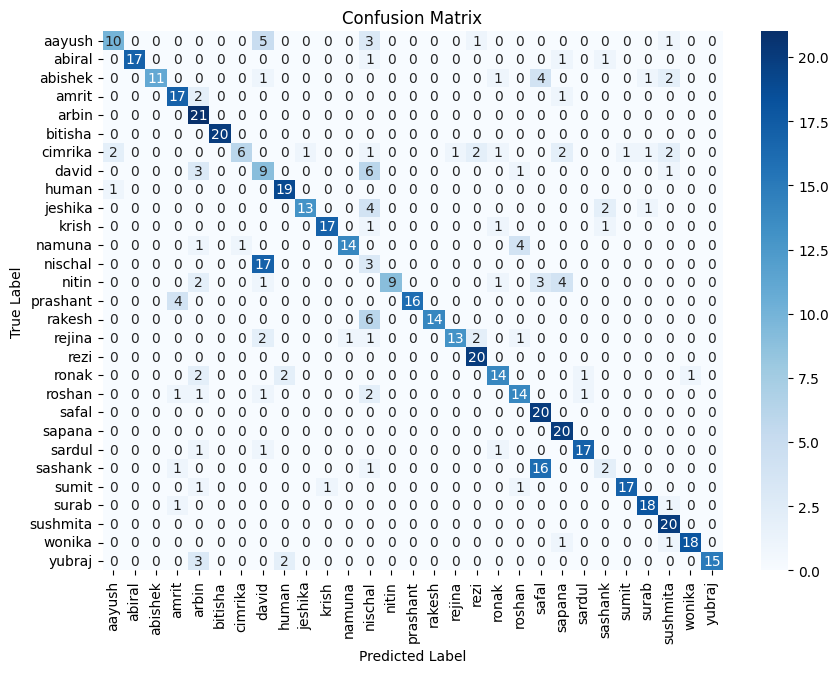


Final Accuracy: 72.98%
Overall Precision: 78.79%
Overall Recall: 72.98%
Overall F1 Score: 73.13%


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model_with_metrics(anchor_dir, test_dir):
    model.eval()

    anchor_dataset = AnchorDataset(anchor_dir)
    test_dataset = TestDataset(test_dir)

    anchor_loader = DataLoader(anchor_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    anchor_embeddings = {}
    with torch.no_grad():
        for images, labels in tqdm(anchor_loader, desc="Processing Anchors"):
            images = images.to(device)
            features = model(images)
            for feat, label in zip(features, labels):
                anchor_embeddings[label] = feat.cpu()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for test_images, true_labels in tqdm(test_loader, desc="Processing Test Images"):
            test_images = test_images.to(device)
            test_features = model(test_images).cpu()

            for test_feat, true_label in zip(test_features, true_labels):
                similarities = {anchor_label: calculate_similarity(anchor_feat, test_feat).item()
                                for anchor_label, anchor_feat in anchor_embeddings.items()}
                
                predicted_label = max(similarities, key=similarities.get)

                y_true.append(true_label)
                y_pred.append(predicted_label)

    # Calculate overall precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    labels = sorted(set(y_true))  
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy = np.trace(cm) / np.sum(cm)
    print(f"\nFinal Accuracy: {accuracy * 100:.2f}%")
    print(f"Overall Precision: {precision * 100:.2f}%")
    print(f"Overall Recall: {recall * 100:.2f}%")
    print(f"Overall F1 Score: {f1 * 100:.2f}%")

    return accuracy, precision, recall, f1

# Test the modified evaluation
anchor_directory=r"D:\cctv_project\ai_final_project\src\notebooks\facenet_tuning\BIZOS"
test_directory=r"D:\cctv_project\ai_final_project\src\notebooks\facenet_tuning\test"
accuracy, precision, recall, f1 = evaluate_model_with_metrics(anchor_directory, test_directory)
